In [1]:
# Used to access the toolkit modules in this directory
import toolkit

### First, we gather the dataset. This is a history of static code metrics (C and indentation) and change metrics for our project.

In [2]:
# Used to indicate where the data should be gathered and stored
rootDirectory = '../dataSets/gitStudy/'

# Call gatherTimeMetrics and measure C, Indent and Change metrics 
# on .c and .h files from the git project's repository
metricsData = toolkit.data.gatherTimeMetrics(rootDirectory, 'https://github.com/git/git', rootDirectory+'git/', '*/*.c */*.h *.c *.h', ['indent','c'], skipEvery=50)

### How many times did we sample from?
### How many features and samples are in our dataset?
### How many unique source files were measured?

In [3]:
print metricsData['times']
print metricsData['data'].shape
print metricsData['data']['entity'].nunique()

308
(15811, 64)
621


### Let's see what affects the net churn of files 
### Which types of files have net churn above and below the mean net churn?

Response variable was netchurn
Model.score: 0.959135
accuracy_score: 0.959135
             precision    recall  f1-score   support

          0       0.97      0.98      0.97      6110
          1       0.92      0.89      0.91      1794

avg / total       0.96      0.96      0.96      7904

roc_auc_score: 0.935571
      name  importance
3    added    0.847304
4  deleted    0.152696
Model.score: 0.949519
accuracy_score: 0.949519
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      6110
          1       0.89      0.89      0.89      1794

avg / total       0.95      0.95      0.95      7904

roc_auc_score: 0.926989
      name  importance
0    added    0.896033
1  deleted    0.103967


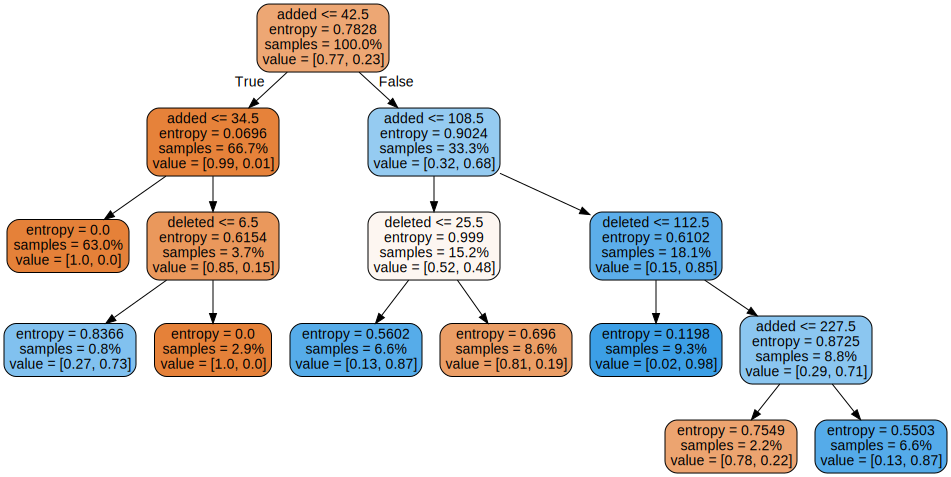

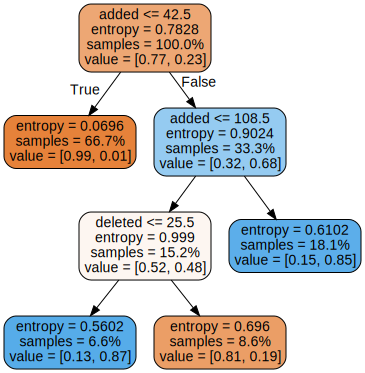

In [4]:
# We instantiate the scikit-learn decision tree classification model
# It is trained with a maximum number of leaf nodes
# Samples are binned so as to maximize information gain at higher nodes ('entropy')
from sklearn.tree import DecisionTreeClassifier
modelInstance = DecisionTreeClassifier(max_leaf_nodes=8, criterion='entropy')
modelSimpler = DecisionTreeClassifier(max_leaf_nodes=4, criterion='entropy')
churnModel = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], 2, 'netchurn', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Some observations:
- The model has very good Precision, Recall and F1-Score: net churn above/below the mean is classified very well by this model
- ROC area under curve is very high: very little compromise between false negative rate and false positive rate
- The model says that the features influencing net churn are (strongest to weakest):
    - Number of lines added
    - Number of lines deleted    
- The 'net churn below the mean' class is over-represented in our data (3 times as many samples as the other class)
    - However, the model still performs well without any steps taken to address class imbalance (e.g. under/over-sampling)
- Interpretation of the visualized decision tree is straightforward:
    - 63% of samples were files with less than 34 lines added 
        - These samples had net churn less than the mean
        - Some of these may be very stable files (over the history of the project)
    - The files with net churn greater than the mean had more than 108 lines added
    - Within this group, there are several subgroups with varying levels of churn

### In the above step, we only performed 2-fold cross validation (1 training set, 1 test set)

### How does this approach perform with more cross-validation folds in time?

In [5]:
# We split the data into 5 equally-sized groups, 
# then perform cross-validation while gradually adding these groups to the training set

# i.e. the train-test splits are with groups of size:
# 1-4, 2-3, 3-2, 4-1

# We omit visualization of decision trees to save space,
# but they can be shown with visualize=True as above
folds = 5
churnModelMoreFolds = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], folds, 'netchurn', modelInstance, modelSimpler, scoreOnly=False) 

Response variable was netchurn
Model.score: 0.967099
accuracy_score: 0.967099
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2607
          1       0.92      0.89      0.90       554

avg / total       0.97      0.97      0.97      3161

roc_auc_score: 0.937410
      name  importance
3    added    0.853814
4  deleted    0.146186
Model.score: 0.928820
accuracy_score: 0.928820
             precision    recall  f1-score   support

          0       0.94      0.95      0.95      2112
          1       0.90      0.88      0.89      1049

avg / total       0.93      0.93      0.93      3161

roc_auc_score: 0.917225
      name  importance
3    added    0.847395
4  deleted    0.152605
Model.score: 0.966150
accuracy_score: 0.966150
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2321
          1       0.95      0.92      0.94       840

avg / total       0.97      0.97      0.97      316

### Each of the subsets still exhibits class imbalance (but not with the same ratio)
### In particular, the 2nd train-test split has the most balanced classes (2:1) among the five splits

### We still see very good performance, and the same features are important throughout
### How far can we go? Let's cross-validate on every sampled time!

In [6]:
folds = metricsData['times'] # This is an attribute of the measured data set: the number of time points measured
#churnModelMoreFolds = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], folds, 'netchurn', modelInstance, scoreOnly=False) 

### Results of this step are omitted for printing. However, the large cross-validation can be run to see them.

### The individual data sets used for training and testing are quite small and imbalanced.

### Many of the same relationships still show up.

### Why is 'added' a much more important factor than 'deleted'? 

In [7]:
print metricsData['data']['netchurn'].mean()
print metricsData['data']['netchurn'].var()
print metricsData['data']['netchurn'].std()
print metricsData['data']['netchurn'].max()
print metricsData['data']['netchurn'].min()

34.7671874012
47557.7271358
218.077342096
4355
-3673


### This codebase is *growing* in general (more added than deleted)

### Some files must experience more churn than others. We know from some of the motivating literature that defects can be correlated with large pre-release churn.

### Let's make some categories of binned churn data and classify them 

Response variable was ['churnLow', 'churnMedium', 'churnHigh', 'churnHigher', 'churnHighest']
Model.score: 0.996457
accuracy_score: 0.996457
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.96      0.81      0.88        97
          2       1.00      1.00      1.00      7762
          3       0.86      0.94      0.90        32
          4       0.00      0.00      0.00         4

avg / total       1.00      1.00      1.00      7904

roc_auc_score: 0.860955
           name  importance
4       deleted    0.548503
3         added    0.383638
0    age-months    0.034864
57  indent_mean    0.032995


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model.score: 0.995445
accuracy_score: 0.995445
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         9
          1       0.90      0.80      0.85        97
          2       1.00      1.00      1.00      7762
          3       0.88      0.88      0.88        32
          4       0.00      0.00      0.00         4

avg / total       0.99      1.00      0.99      7904

roc_auc_score: 0.751549
      name  importance
2  deleted      0.5991
1    added      0.4009


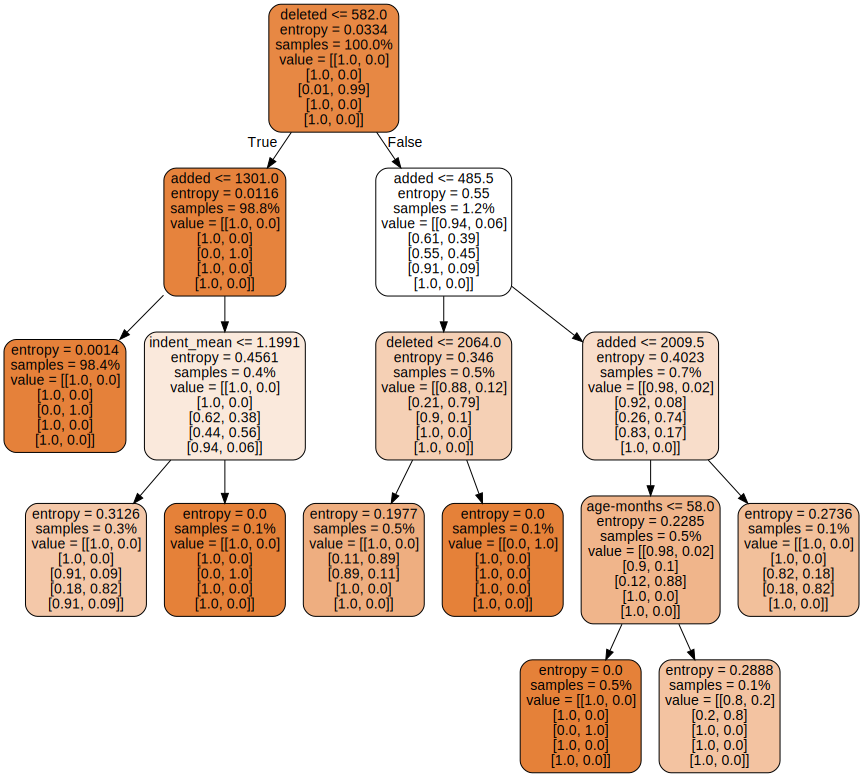

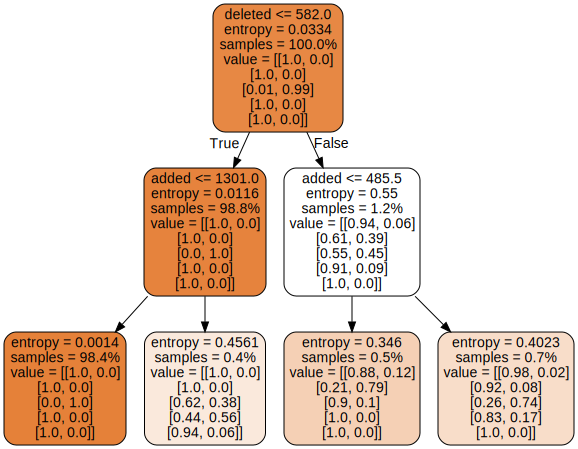

In [8]:
churnBinnedCategories = ['churnLow','churnMedium','churnHigh','churnHigher', 'churnHighest']
dataSetUpdated = toolkit.utilities.addBinnedResponseCategory(metricsData['data'], 'netchurn', churnBinnedCategories)

from sklearn.tree import DecisionTreeClassifier
modelInstance = DecisionTreeClassifier(max_leaf_nodes=8, criterion='entropy')
churnModelCategories = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, 2, churnBinnedCategories, modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Now we're seeing something interesting. The vast majority of the files exhibit very low amounts of churn. A select few files receive most of the lines added/deleted. Does the class imbalance impact the validity of this model? Let's try more cross-validation to see.

Response variable was ['churnLow', 'churnMedium', 'churnHigh', 'churnHigher', 'churnHighest']
Model.score: 0.992598
accuracy_score: 0.992598
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.57      0.55      0.56        31
          2       1.00      1.00      1.00      5215
          3       0.59      0.68      0.63        19
          4       0.00      0.00      0.00         1

avg / total       0.99      0.99      0.99      5269

roc_auc_score: 0.691071
             name  importance
4         deleted    0.528127
3           added    0.279475
44  halstead_mean    0.090079
58      indent_sd    0.055215
1       n-authors    0.028592
0      age-months    0.018512
Model.score: 0.994686
accuracy_score: 0.994686
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.96      0.81      0.88        95
          2       1.00      1.00      1.00  

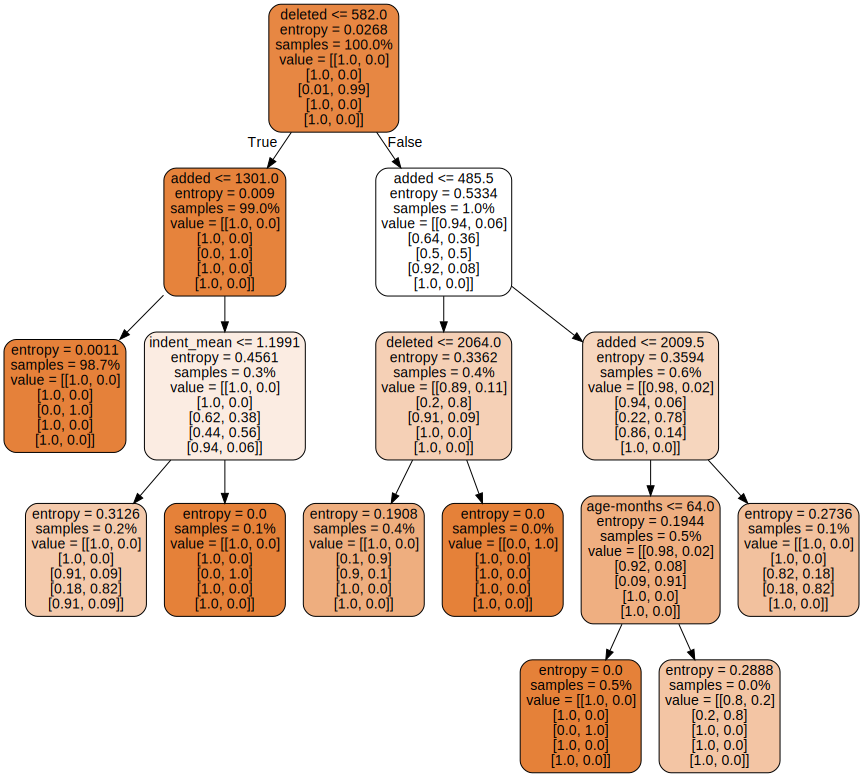

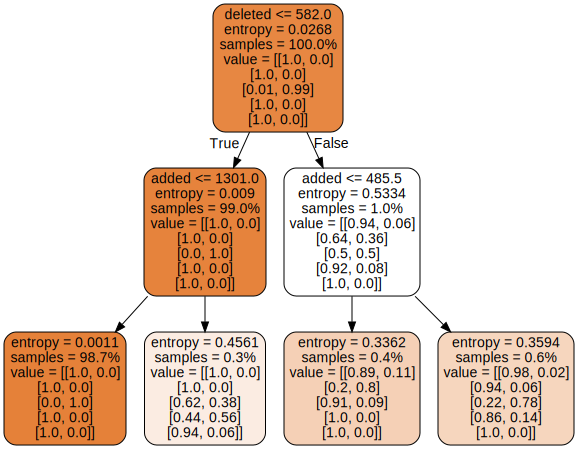

In [9]:
folds = 3
churnModelCategories = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, folds, churnBinnedCategories, modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Let's look at this from another point of view. What characterises the files which have the most lines added?

Response variable was added
Model.score: 0.975962
accuracy_score: 0.975962
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      6270
          1       0.97      0.91      0.94      1634

avg / total       0.98      0.98      0.98      7904

roc_auc_score: 0.953173
       name  importance
6  netchurn    0.665052
3   deleted    0.317658
2    n-revs    0.017290
Model.score: 0.915992
accuracy_score: 0.915992
             precision    recall  f1-score   support

          0       0.98      0.91      0.94      6270
          1       0.73      0.95      0.82      1634

avg / total       0.93      0.92      0.92      7904

roc_auc_score: 0.927365
       name  importance
2  netchurn    0.702259
1   deleted    0.297741


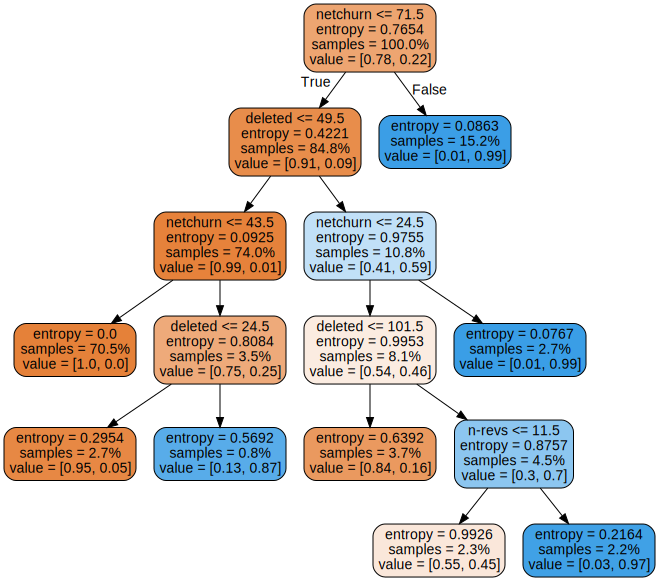

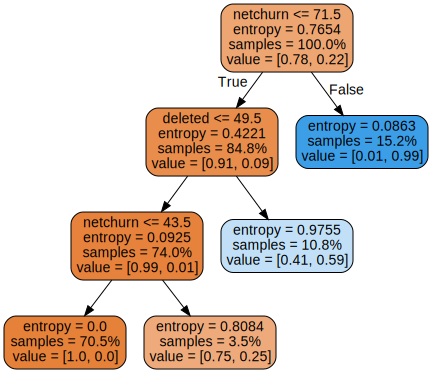

In [10]:
addedModel = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Net churn and deleted lines are strongly related. What do we find if we're not allowed to use these in our decision tree?

Response variable was added
Model.score: 0.852100
accuracy_score: 0.852100
             precision    recall  f1-score   support

          0       0.88      0.94      0.91      6270
          1       0.70      0.51      0.59      1634

avg / total       0.84      0.85      0.84      7904

roc_auc_score: 0.724419
            name  importance
2         n-revs    0.921682
54  indent_lines    0.055245
12    nstatement    0.023073
Model.score: 0.852100
accuracy_score: 0.852100
             precision    recall  f1-score   support

          0       0.88      0.94      0.91      6270
          1       0.70      0.51      0.59      1634

avg / total       0.84      0.85      0.84      7904

roc_auc_score: 0.724419
     name  importance
0  n-revs           1


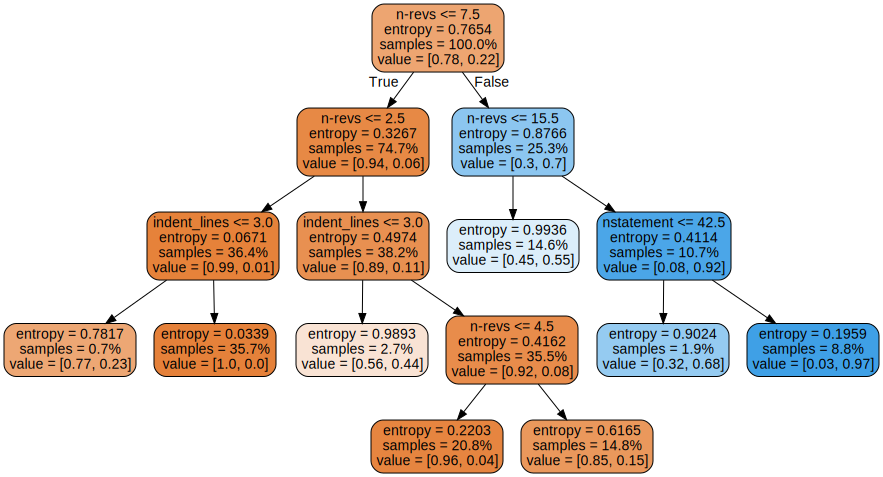

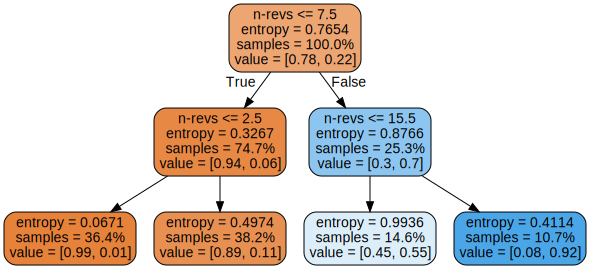

In [11]:
alteredData = metricsData['data'].drop(['netchurn','deleted'], axis=1)
addedModel = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData, 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### The model uses n-revs as the most important feature, but it does not classify '# lines added above the mean' very well

Response variable was added
Model.score: 0.822748
accuracy_score: 0.822748
             precision    recall  f1-score   support

          0       0.83      0.98      0.90      6270
          1       0.72      0.23      0.35      1634

avg / total       0.81      0.82      0.78      7904

roc_auc_score: 0.604104
             name  importance
1       n-authors    0.816130
2   fractal-value    0.101745
53   indent_lines    0.082125
Model.score: 0.813892
accuracy_score: 0.813892
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      6270
          1       0.60      0.30      0.40      1634

avg / total       0.79      0.81      0.79      7904

roc_auc_score: 0.623862
        name  importance
0  n-authors           1


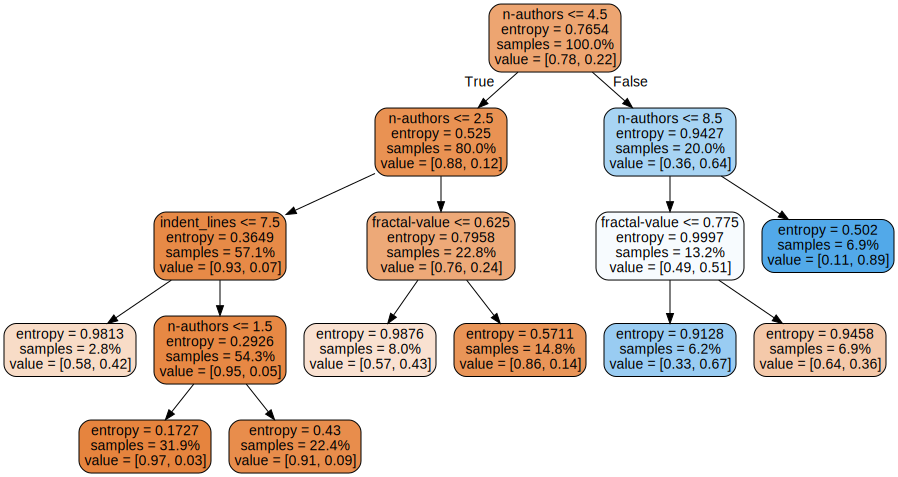

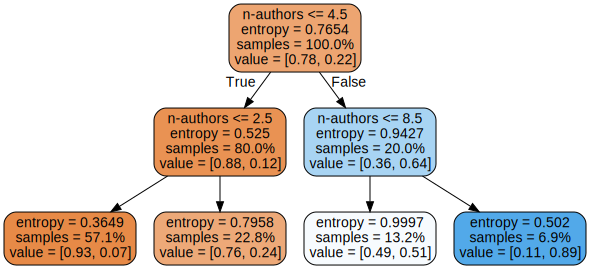

In [12]:
alteredData2 = metricsData['data'].drop(['netchurn','deleted','n-revs'], axis=1)
addedModel2 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData2, 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### n-authors has similar problems with identifying the minority class

Response variable was added
Model.score: 0.797950
accuracy_score: 0.797950
             precision    recall  f1-score   support

          0       0.83      0.94      0.88      6270
          1       0.52      0.24      0.33      1634

avg / total       0.76      0.80      0.77      7904

roc_auc_score: 0.593452
             name  importance
1   fractal-value    0.822226
52   indent_lines    0.082591
2             soc    0.053074
44     nfunction3    0.042108
Model.score: 0.799848
accuracy_score: 0.799848
             precision    recall  f1-score   support

          0       0.80      0.99      0.89      6270
          1       0.62      0.08      0.15      1634

avg / total       0.77      0.80      0.73      7904

roc_auc_score: 0.534691
            name  importance
0  fractal-value           1


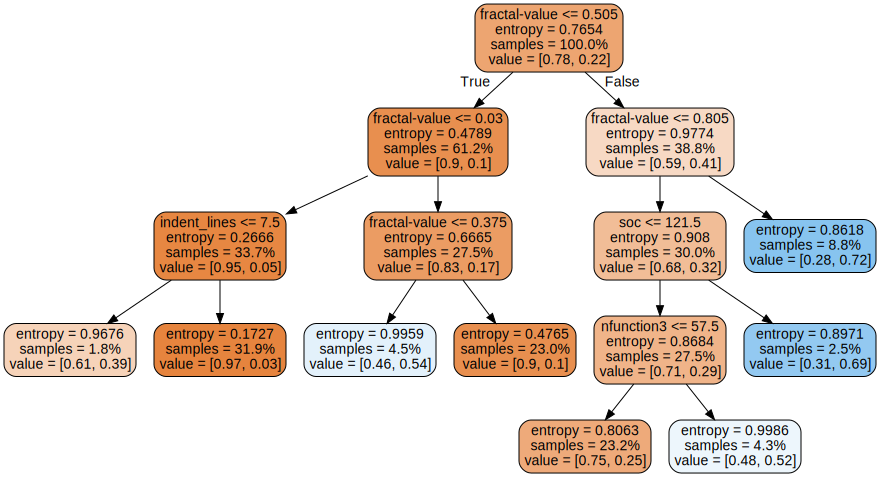

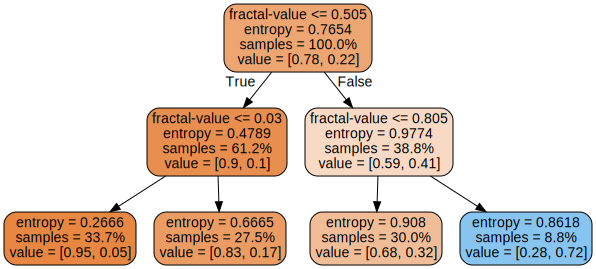

In [13]:
alteredData3 = metricsData['data'].drop(['netchurn','deleted','n-revs','n-authors'], axis=1)
addedModel3 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData3, 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### fractal-value is derived from n-revs and n-authors

### Let's get rid of it and build a regression model for nline
### This model will predict the sizes of files based on their other static features

In [14]:
from sklearn.tree import DecisionTreeRegressor
modelInstanceR = DecisionTreeRegressor(max_leaf_nodes=8)
modelInstanceRsimpler = DecisionTreeRegressor(max_leaf_nodes=4)
alteredData4 = metricsData['data'].drop(['netchurn','deleted','n-revs','n-authors','fractal-value'], axis=1)
nlineModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData4, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.969767
                    name  importance
51          indent_lines    0.989240
50    unique_nidentifier    0.004563
285  entity_cache-tree.c    0.003730
17                 nenum    0.001931
32        ncpp_directive    0.000536
Model.score: 0.963244
                  name  importance
2         indent_lines    0.991665
1   unique_nidentifier    0.004586
3  entity_cache-tree.c    0.003749


### We see that the number of indented lines is a very good predictor of the number of lines

### Is the model using indent_lines because it is correlated with nline?

In [15]:
# We use the Spearman measure of rank correlation
metricsData['data']['nline'].corr(metricsData['data']['indent_lines'], method='spearman')

0.87174000713395294

### Let's remove indent_lines from this data set
### Are we still able to regress on nline (and with high performance)?

In [16]:
alteredData5 = metricsData['data'].drop(['indent_lines','nchar','nstatement','nidentifier'], axis=1)
nlineModelR2 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData5, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.826246
                  name  importance
12           nfunction    0.748858
52  unique_nidentifier    0.129530
34       ncomment_char    0.074467
46          nfunction3    0.027805
44        halstead_max    0.019341
Model.score: 0.780705
                 name  importance
0           nfunction    0.852537
4  unique_nidentifier    0.147463


### cqmetrics provides several measures of the 'number of functions' contained in a file (each calculated differently)

### The model uses these to predict the size of files

In [17]:
alteredData6 = metricsData['data'].drop(['indent_lines','nchar','nstatement','nidentifier', 'nfunction','nfunction2','nfunction3'], axis=1)
nlineModelR3 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData6, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.755902
                   name  importance
49   unique_nidentifier    0.755825
17            ninternal    0.084898
33        ncomment_char    0.052065
26              nstruct    0.035731
20                ngoto    0.026499
32             ncomment    0.023812
429   entity_log-tree.c    0.021170
Model.score: 0.720746
                 name  importance
5  unique_nidentifier    0.846590
0           ninternal    0.095093
4       ncomment_char    0.058317


In [18]:
alteredData7 = metricsData['data'].drop(['indent_lines','nchar','nstatement','nidentifier', 'nfunction','nfunction2','nfunction3', 'unique_nidentifier'], axis=1)
nlineModelR4 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData7, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.694157
                  name  importance
17           ninternal    0.713856
32            ncomment    0.101620
26             nstruct    0.091231
20               ngoto    0.041615
428  entity_log-tree.c    0.031404
43         halstead_sd    0.020273
Model.score: 0.725020
        name  importance
0  ninternal    0.802897
2    nstruct    0.102610
3   ncomment    0.094493


### Our regression model of nline needs the number of (unique) identifiers, and the number of functions in a file to explain the variance in our dataset

### Without these features, the model rapidly loses accuracy.

### From all the features we measure, the only ones which are strong predictors of size are other measures of such (which are bound to be correlated - lines of source code necessarily add identifiers, operators, functions etc as counted by Halstead's metrics)

### We see that the maximum Halstead complexity metric among the functions in each file is a (weak) predictor under this model. The measures from which it is calculated have a much stronger correlation with size.

### What about modelling these measures of complexity?

In [19]:
cycloData = metricsData['data'].drop(['cyclomatic_sd', 'cyclomatic_mean'], axis=1)
cycloModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, cycloData, 2, 'cyclomatic_max', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was cyclomatic_max
Model.score: 0.639872
                      name  importance
47            halstead_max    0.806377
15              nstatement    0.080198
17  statement_nesting_mean    0.072845
22                  nconst    0.021204
58              indent_max    0.019376
Model.score: 0.579328
                     name  importance
3            halstead_max    0.865349
0              nstatement    0.088993
1  statement_nesting_mean    0.045658


### Cyclomatic complexity seems to be similar to Halstead complexity for our dataset
### The measures which are used to derive both of these are also predictors. Let's remove them and repeat..

In [20]:
cycloData2 = metricsData['data'].drop(['halstead_sd','nidentifier','halstead_mean','halstead_min','cyclomatic_sd', 'cyclomatic_mean', 'halstead_max','nstatement','statement_nesting_mean'], axis=1)
cycloModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, cycloData2, 2, 'cyclomatic_max', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was cyclomatic_max
Model.score: 0.486573
                  name  importance
19           ninternal    0.526625
48         indent_mean    0.308199
33            ntypedef    0.064537
46  unique_nidentifier    0.038665
51          indent_max    0.032551
36      ncpp_directive    0.029424
Model.score: 0.474307
          name  importance
0    ninternal    0.630822
4  indent_mean    0.369178


### The number of static variables and the mean indentation level of files are strong predictors of cyclomatic complexity for our dataset

### This indentation predictor is similar to the findings of Hindle. 
### What about the 'ninternal' (static linkage) result? The files containing functions with higher cyclomatic complexity also have more variables (which are shared between functions in the same file)?
### This may be starting to give some insight into our codebase. Perhaps our code overuses file-global variables together with functions which are difficult to test.

### Can we model indentation? What leads to 'wider' files?

In [21]:
indentData = metricsData['data'].drop(['indent_sd','indent_median','indent_max','indent_lines'],axis=1)
indentModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, indentData, 2, 'indent_mean', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was indent_mean
Model.score: 0.786891
                      name  importance
47            halstead_max    0.458227
20    statement_nesting_sd    0.291467
15              nstatement    0.091504
17  statement_nesting_mean    0.052660
54           cyclomatic_sd    0.036665
8                    nchar    0.036065
46         halstead_median    0.033412
Model.score: 0.664954
                   name  importance
5          halstead_max    0.544731
3  statement_nesting_sd    0.346490
1            nstatement    0.108778


### The files with more nesting (which drives Halstead's complexity) are more indented

### This tells us that our codebase uses indentation to *indicate* nesting frequently. This is typical in C programming, of course. However, there is value in this seemingly simple result: to locate the files with high syntax-driven measures of complexity in this codebase, we can use a heuristic like the level of indentation instead.

### It is important to also consider that our dataset does not have other measures of complexity which have *not* been represented by this model.  Halstead and McCabe's measures are dominant in the measurement of C programs, but other measures of complexity which are not strongly connected with structural *nesting* may not be predicted by indentation. In other words, indentation does not necessarily predict *complexity* - it predicts *Halstead and McCabe complexity*.

In [22]:
indentModelC = toolkit.refinement.makeAndUpdateModel(rootDirectory, indentData, 2, 'indent_mean', modelInstance, modelSimpler, visualize=False, scoreOnly=False)

Response variable was indent_mean
Model.score: 0.942687
accuracy_score: 0.942687
             precision    recall  f1-score   support

          0       0.90      0.95      0.92      2917
          1       0.97      0.94      0.95      4987

avg / total       0.94      0.94      0.94      7904

roc_auc_score: 0.944123
                      name  importance
47            halstead_max    0.506472
20    statement_nesting_sd    0.254331
15              nstatement    0.079130
17  statement_nesting_mean    0.049194
46         halstead_median    0.042261
54           cyclomatic_sd    0.037608
8                    nchar    0.031003
Model.score: 0.908148
accuracy_score: 0.908148
             precision    recall  f1-score   support

          0       0.82      0.96      0.89      2917
          1       0.98      0.88      0.92      4987

avg / total       0.92      0.91      0.91      7904

roc_auc_score: 0.919242
                   name  importance
5          halstead_max    0.602991
3  stateme

### We can use the DecisionTreeClassifier to bin samples above and below the mean indentation level, more effectively than we can predict the indentation level itself via regression.

### To what degree is this true? Let's try adding more categories as before.

In [23]:
indentBinnedCategories = ['iLow','iMedium','iHigh','iVeryHigh']
dataSetUpdated = toolkit.utilities.addBinnedResponseCategory(indentData, 'indent_mean', indentBinnedCategories)
indentModelC = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, 2, indentBinnedCategories, modelInstance, modelSimpler, visualize=False, scoreOnly=False)

Response variable was ['iLow', 'iMedium', 'iHigh', 'iVeryHigh']
Model.score: 0.758350
accuracy_score: 0.758350
             precision    recall  f1-score   support

          0       0.80      0.78      0.79      1849
          1       0.67      0.54      0.60      2285
          2       0.78      0.90      0.84      3622
          3       0.53      0.26      0.35       148

avg / total       0.75      0.76      0.75      7904

roc_auc_score: 0.763288
                      name  importance
54           cyclomatic_sd    0.587593
20    statement_nesting_sd    0.205392
17  statement_nesting_mean    0.139729
12         line_length_max    0.067286
Model.score: 0.712171
accuracy_score: 0.712171
             precision    recall  f1-score   support

          0       0.80      0.78      0.79      1849
          1       0.54      0.74      0.62      2285
          2       0.85      0.69      0.76      3622
          3       0.00      0.00      0.00       148

avg / total       0.73      0.71   

### This model suffers from class imbalance: with only 8 leaves, it loses accuracy when predicting the files with the most indentation. This is a common issue with decision trees being exposed by our dataset. It is not a property of our codebase or of C source code.

### In this case, we can use an *ensemble model* to make up for the loss of accuracy in the minority class. However, we do so at the expense of model interpretation. 

### We build a random forest: a group of decision trees are made with the first decision chosen at random. The group of trees is used to classify each sample, and a majority voting scheme decides the model output.

### This has the effect of creating more trees. Some may resemble the above single tree (which accurately modelled *most* of our data). Others may be highly inaccurate, except for small subsets of the data. 

### The training of this model is 'embarassingly parallel': we use all the available CPU cores in parallel to create our decision trees.

### Forest models can be difficult to tune, and to interpret. We omit visualization of the many trees. For automated classification tasks used in a production environment (as opposed to empirical research), forests may be valuable despite their lack of interpretability.

In [24]:
# For parallel construction of forest models
import psutil
cores = psutil.cpu_count()

from sklearn.ensemble import RandomForestClassifier
# We build a forest of n_estimators trees, with no restriction on the breadth/depth of trees.
modelCF = RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=cores)
modelCFsimpler = RandomForestClassifier(n_estimators=20, max_leaf_nodes=2, criterion='entropy', n_jobs=cores) # Each tree makes one decision
updatedModelCF = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, 2, indentBinnedCategories, modelCF, modelCFsimpler, scoreOnly=False, visualize=False)

Response variable was ['iLow', 'iMedium', 'iHigh', 'iVeryHigh']
Model.score: 0.899798
accuracy_score: 0.899798
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      1849
          1       0.87      0.86      0.87      2285
          2       0.92      0.93      0.92      3622
          3       1.00      0.19      0.32       148

avg / total       0.91      0.90      0.90      7904

roc_auc_score: 0.848673
                                   name    importance
17               statement_nesting_mean  5.725211e-02
51                      cyclomatic_mean  4.245716e-02
53                       cyclomatic_max  4.235262e-02
54                        cyclomatic_sd  4.165558e-02
20                 statement_nesting_sd  4.037629e-02
47                         halstead_max  3.995474e-02
45                        halstead_mean  3.905663e-02
48                          halstead_sd  3.838915e-02
15                           nstatement  2.755298e-02
46  

### The resulting forest together uses many features. Many of these are named entities - our trees are individually modelling the files in our codebase. This showcases a possible threat to the use of forest models with our dataset: there may be a tendency to model the one-hot encoded entities.

### We also note that the minority class is predicted with high Precision, but low Recall. From the high-indentation files we predict, they are predicted correctly. However, most of the high-indentation files are missed even by this model. The F1-Score (the harmonic mean of Precision and Recall) is similarly low.

### Since the training of a random forest includes random choices (the initial splits in each tree), the results of this cell may vary each time it is run. The models before and after the update are likely to differ.

### In this case study, we have used the toolkit to do the following:
- Gather the Git dataset
- Create classification models of net churn: above and below the mean, in five binned categories
- Create regression models of file size and cyclomatic complexity
- Create regression and classification models of mean indentation 
    - Including a brief test of random forests to improve classification performance with a very small minority class we wish to predict: the files with the highest mean indentation level